# Multi Speaker & Context Aware AI Podcast Generation

Hi everyone, welcome to this notebook!  

Today, we'll be building an AI-powered podcast that not only converts my Medium blog into a podcast but also incorporates insights from my previous work on related topics. This approach makes the podcast feel more natural and enhances trust in AI-generated content.  


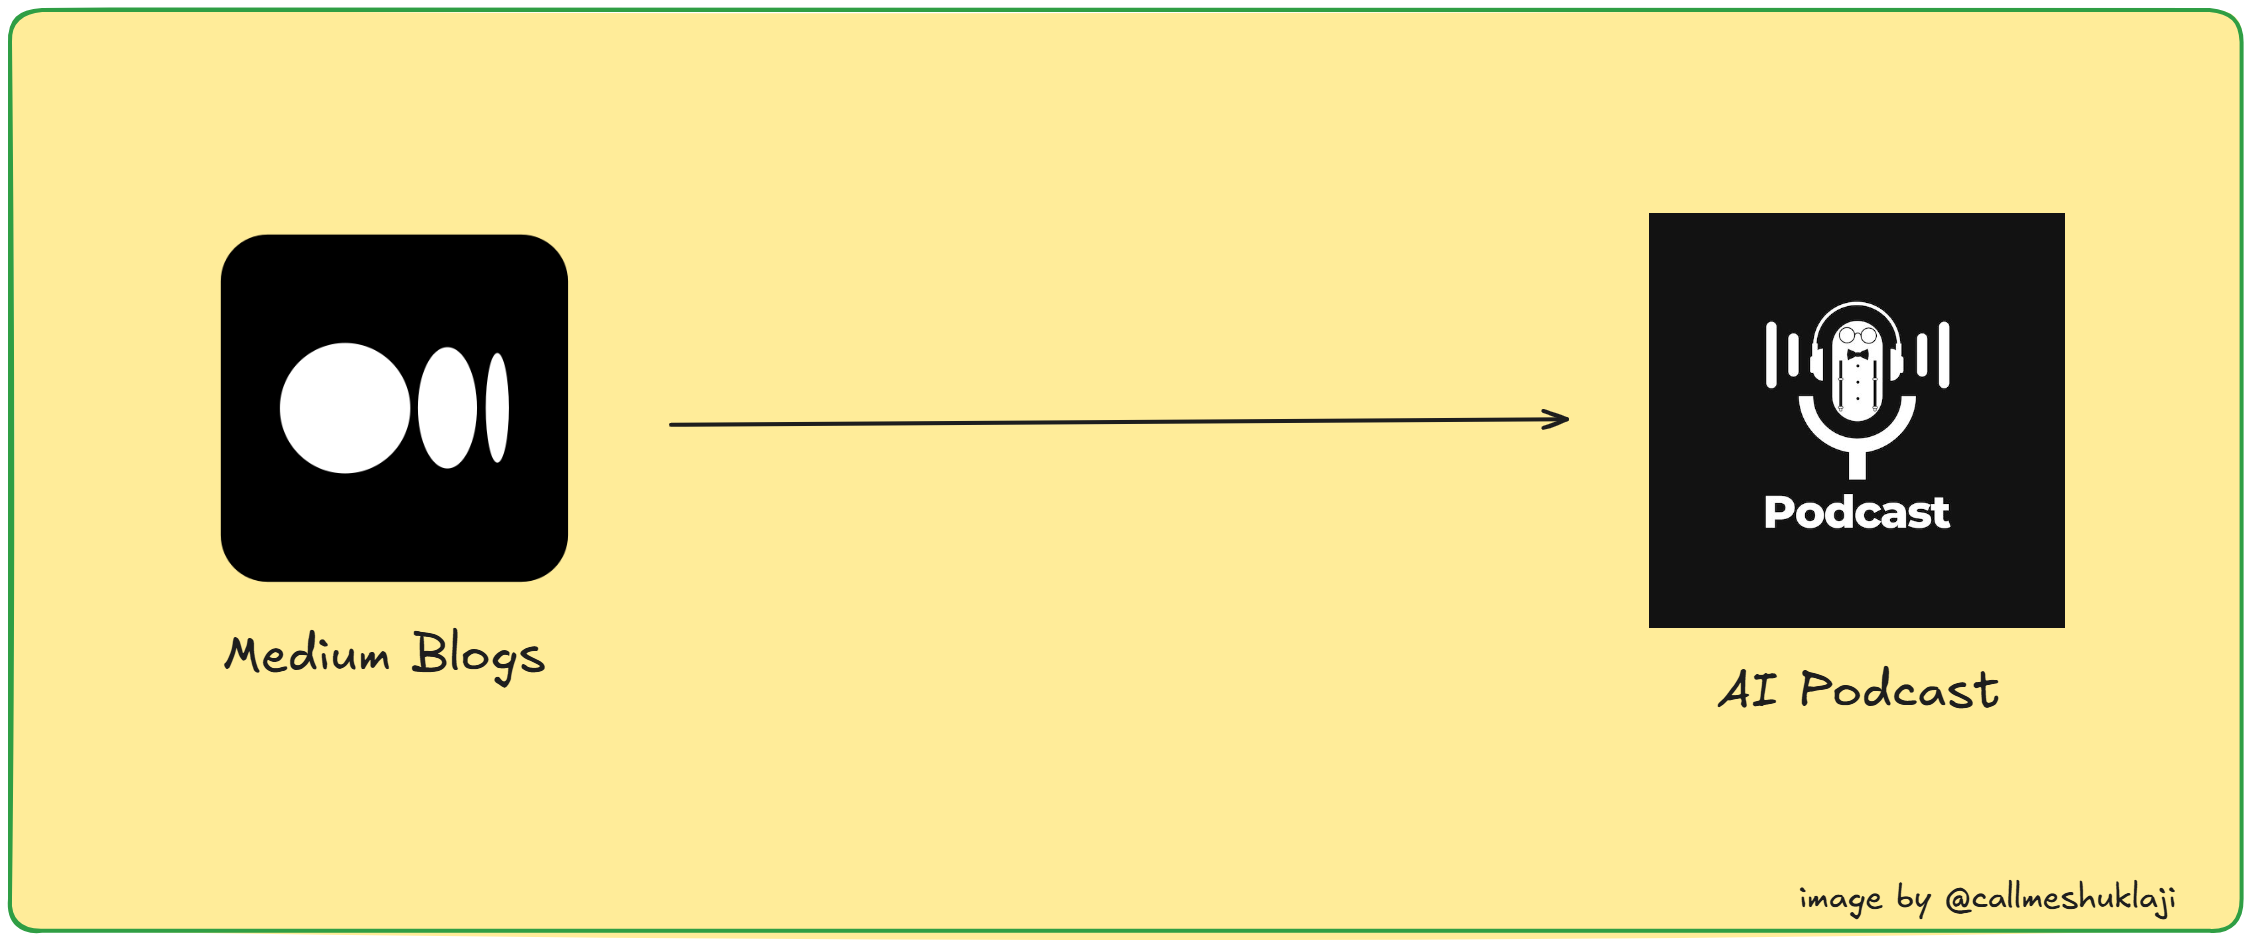

### **Tech Stack Used:**  
1. **LangChain**  
2. **ElevenLabs** (for TTS)  
3. **Gemini** (LLM)  
4. **LanceDB** (for context retrieval)

How to use this notebook?
If you want to generate a podcast with my configuration, you simply need to replace sample blog text used to generate podcast with you blog. If you want to modify and change voices or models used or number of speakers in the podcast, please change configuration at multiple steps as explained in the blog.

Let's go.


Listen to this podcast I created using the below code - [PODCAST](https://github.com/shuklaji28/vectordb-recipes/blob/main/examples/Multi_Speaker_Context_Aware_Podcast_Generation/Podcasts/podcast.mp3)

References I used while building this - [1.](https://www.youtube.com/watch?v=FT-OyDzjAZo&t=503s)

#### Install Necessary Libraries and Dataset

In [27]:
!pip install feedparser #to scrape content from feed directly.
!pip install tantivy #required for FTS using LanceDB
!pip install lancedb
!pip install sentence-transformers #not mandatory
!pip install smallestai  #to generate AI Voices

# Install required packages for Podcast Generation
!pip install -q langchain langchain_community langchain-google-genai pydub python-dotenv

# Install ffmpeg for audio processing
!apt-get update -qq && apt-get install -qq ffmpeg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=b25b87ad57a90567f78a495af6e139a97b0917a85c1b21ca8dc6b3cbaa358576
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:
!pip install keybert

#need to change url with lanceDB username
!wget https://raw.githubusercontent.com/shuklaji28/vectordb-recipes/main/examples/Multi_Speaker_Context_Aware_Podcast_Generation/urls.json


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00
--2025-03-18 15:07:58--  https://raw.githubusercontent.com/shuklaji28/vectordb-recipes/main/examples/Multi_Speaker_Context_Aware_Podcast_Generation/urls.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [text/plain]
Saving to: ‘urls.json’

urls.json           100%[===================>]   1.10K  --.-KB/s    in 0s      

2025-03-18 15:07:59 (42.6 MB/s) - ‘urls.json’ saved [1127/1127]



In [59]:
import os
import json
import shutil
import re
import requests
import tempfile
import base64

from pydub import AudioSegment
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from google.colab import files
import pandas as pd
from IPython.display import display, Audio, HTML
from langchain_core.output_parsers import JsonOutputParser

from bs4 import BeautifulSoup
import lancedb
from sentence_transformers import SentenceTransformer
from lancedb.embeddings import get_registry
import numpy as np
from pprint import pprint
import time
from keybert import KeyBERT


#### Helper Functions

In [58]:

def generate_conversation(article, podcast_name, speakers, additional_context):
    # Create LangChain Gemini model
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        google_api_key=gemini_api_key,
        temperature=0.9,
    )

    # Create system prompt
    number_of_speakers = len(speakers)
    speaker_names = ", ".join([s["name"] for s in speakers])
    host_name = speakers[0]["name"] if speakers else "Host"

    context_text = additional_context

    # # Format additional context from LanceDB for prompt
    # context_text = ""
    # if additional_context:
    #     context_text = "Here are some relevant contexts from previous blogs that should be referenced in the podcast:\n\n"
    #     for idx, ctx in enumerate(additional_context, 1):
    #         context_text += f"{idx}. Title: {ctx['title']}\n   Excerpt: {ctx['excerpt']}\n\n"

    system_prompt = f"""You are an experienced podcast script writer for Lance DB
    Your task is to create an engaging conversation between different people based on the article provided.

    The speakers are: given as input.
    - first name of the pseaker list is the host of the podcast.
    - Make the conversation between 30000-50000 characters for this demo (normally would be longer)
    - Use short sentences that can be easily used with speech synthesis
    - Include conversational fillers (um, uh, well, hmm) occasionally to make it sound natural
    - Show excitement and engagement during the conversation
    - Do not mention last names
    - Avoid formal introductions like "Thanks for having me on the show"
    - Make sure the script discusses the main article thoroughly

    The response must be in JSON format with an array of objects, each containing:
    - "speaker": the name of the speaker (must match exactly one of: {speaker_names})
    - "text": what they say (a short paragraph or a few sentences at a time)
    """

    # Create prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", f"""Here's the article content to discuss:\n\n{article}
        <article end>

        Here's for your reference the additional context from previous blogs when relevant during the conversation.
        {context_text}

        Number of Speakers in the podcast are - {number_of_speakers}
        Speakers are - {speaker_names}
        """)
            ])

    # Create output parser
    output_parser = JsonOutputParser()

    # Create chain
    chain = prompt | llm | output_parser

    # Execute chain
    response = chain.invoke({"article": article, "number_of_speakers" : number_of_speakers, "context_text" : additional_context, "speaker_names" : speaker_names})

    return response

#if you want to go for more extensive scraping, you can use this code :) #run this cell, only if you are not satisfied with the output generated using FeedParser.
# For me normal scraping content works and is enough to give the context of other blogs.
def extract_medium_blog_2(url):
    # Add User-Agent to avoid being blocked
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        # Get the page content
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise exception for 4XX/5XX responses

        # Parse the HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        print(soup)
        # Extract title - Medium typically uses <h1> for the main title
        title_element = soup.find('h1')
        title = title_element.text.strip() if title_element else "Title not found"

        # Find the article content
        # Medium often puts the main content in an <article> tag
        article = soup.find('article')

        # If article tag is found, extract content from it
        if article:
            paragraphs = article.find_all('p')
        else:
            # Fallback to main content area
            content_section = soup.find('section', class_=lambda c: c and 'section-content' in c)
            if content_section:
                paragraphs = content_section.find_all('p')
            else:
                # Last resort: get all paragraphs
                paragraphs = soup.find_all('p')

        # Extract text from paragraphs
        content = "\n\n".join([p.text.strip() for p in paragraphs if p.text.strip()])

        # Extract headings (h2, h3, h4)
        headings = []
        for heading_tag in ['h2', 'h3', 'h4']:
            headings.extend([h.text.strip() for h in soup.find_all(heading_tag) if h.text.strip()])

        # Try to extract publication date
        date = None
        time_element = soup.find('time')
        if time_element and time_element.has_attr('datetime'):
            date = time_element['datetime']

        # Extract author name if available
        author_element = soup.find('a', class_=lambda c: c and 'author' in c)
        author = author_element.text.strip() if author_element else "Author not found"

        return {
            "title": title,
            "author": author,
            "date": date,
            "headings": headings,
            "content": content,
            "url": url
        }

    except Exception as e:
        print(f"Error extracting blog from {url}: {str(e)}")
        return {"error": str(e), "url": url}

def scrape_medium_blogs_2(blog_urls):
    results = []
    for url in blog_urls:
        print(f"Scraping: {url}")
        blog_data = extract_medium_blog(url)
        results.append(blog_data)
    return results


#using this one in this notebook
def extract_medium_blog(url):

    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    title = soup.find("h1").text
    # date = soup.find("time")["datetime"]
    paragraphs = soup.find_all("p")
    content = "\n".join([p.text for p in paragraphs])
    headings = [h.text for h in soup.find_all(["h2", "h3", "h4"])]
    return {"title": title,"headings" : headings,"content": content, "url": url}

# ElevenLabs TTS function
def synthesize_speech_elevenlabs(text, voice_id, index, speaker_name):

    try:
        elevenlabs_url = f"https://api.elevenlabs.io/v1/text-to-speech/{voice_id}"
        elevenlabs_headers = {
            "Accept": "audio/mpeg",
            "Content-Type": "application/json",
            "xi-api-key": elevenlabs_api_key
        }

        data = {
            "text": text,
            "model_id": "eleven_turbo_v2_5",
            "voice_settings": {
                "stability": 0.5,
                "similarity_boost": 0.75
            }
        }
        response = requests.post(
            elevenlabs_url,
            json=data,
            headers=elevenlabs_headers
        )

        if response.status_code != 200:
            print(f"Error with ElevenLabs API: {response.text}")
            return None

        filename = f"audio-files/{index}_{speaker_name}.mp3"
        with open(filename, "wb") as out:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    out.write(chunk)

        time.sleep(2) #intentionally slowing down the process to make sure you don't get error lol
        return filename

    except Exception as e:
        print(f"Error with ElevenLabs synthesis: {str(e)}")
        return None

# Smallest AI TTS function
def synthesize_speech_smallest(text, voice_id, index, speaker_name, model="lightning"):
    try:
        client = Smallest(api_key=smallest_api_key)

        # Create filename
        filename = f"audio-files/{index}_{speaker_name}.wav"

        # Synthesize audio
        result = client.synthesize(
            text=text,
            save_as=filename,
            voice_id=voice_id
        )

        with open(filename, "wb") as out:
            for chunk in result.iter_content(chunk_size=1024):
                if chunk:
                    out.write(chunk)
        return filename

    except Exception as e:
        print(f"Error with Smallest AI synthesis: {str(e)}")
        return None

# Function to generate the podcast audio from conversation data
def generate_audio(conversation, speakers_map):
    # if os.path.exists('audio-files'):
    #     shutil.rmtree('audio-files')
    os.makedirs('audio-files', exist_ok=True)

    file_paths = []

    for index, part in enumerate(conversation):
        speaker_name = part['speaker']
        text = part['text']

        # Find the voice configuration for this speaker
        if speaker_name in speakers_map:
            voice_config = speakers_map[speaker_name]
            if voice_config["service"] == "elevenlabs":
                file_path = synthesize_speech_elevenlabs(
                    text,
                    voice_config["voice_id"],
                    index,
                    speaker_name
                )
            elif voice_config["service"] == "smallest":
                file_path = synthesize_speech_smallest(
                    text,
                    voice_config["voice_id"],
                    index,
                    speaker_name,
                    voice_config.get("model", "lightning")  # Default to lightning model
                )

            else:  # Google TTS
                print("Define TTS Model to use. For example, GCTTS, Smallest, Bhashini, Elevenlabs etc.")

            if file_path:
                file_paths.append(file_path)

    if not file_paths:
        print("No audio files were generated.")
        return None
    return file_paths

#if your blogs are not behind paywall, you can use this function to scrape content and save it completely into vector database
import feedparser
def fetch_medium_blogs(rss_url):
    """
    Fetches blog posts from a Medium RSS feed and extracts relevant details.

    Parameters:
        rss_url (str): The URL of the Medium RSS feed.

    Returns:
        list: A list of dictionaries containing blog title, link, published date, summary, and content.
    """
    # Parse the feed
    feed = feedparser.parse(rss_url)

    # Extract blog information
    blogs = []

    for entry in feed.entries:
        blog = {
            "title": entry.title,
            "link": entry.link,
            "published": entry.published,
            "summary": entry.summary,
            "content": entry.content[0].value if "content" in entry else entry.summary
        }
        blogs.append(blog)

    return blogs

def extract_keywords(text, num_keywords=5):
    """
    Extracts important keywords/phrases from the given text using KeyBERT.

    Parameters:
        text (str): The input text for keyword extraction.
        num_keywords (int): The number of keywords/phrases to extract.

    Returns:
        list: A list of extracted keywords/phrases.
    """
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=num_keywords)
    return [kw[0] for kw in keywords]  # Extract only the keyword phrases

#you can save this conversation in another vector table instance and use it as context for next blog.
def save_conversation(conversation):
    json_output_path = "./conversation/conversation.json"
    os.makedirs(os.path.dirname(json_output_path), exist_ok=True)
    with open(json_output_path, "w") as json_file:
          json.dump(conversation, json_file, indent=4)
    print(f"Conversation saved to {json_output_path}")


# Function to sort filenames naturally
def natural_sort_key(filename):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', filename)]

# Function to merge audio files
def merge_audios(audio_folder, output_file):
    combined = AudioSegment.empty()
    audio_files = sorted(
        [f for f in os.listdir(audio_folder) if f.endswith(".mp3") or f.endswith(".wav")],
        key=natural_sort_key
    )

    for filename in audio_files:
        audio_path = os.path.join(audio_folder, filename)
        audio = AudioSegment.from_file(audio_path)
        combined += audio
    combined.export(output_file, format="mp3")
    return output_file





#### Set-Up Configurations

In [31]:
# Create directory for audio files
!mkdir -p audio-files

# Define the list of speakers, with the host as the first entry
speakers_list = [
    {"name": "Shresth"},  # Host
    {"name": "Arjun"},
    {"name": "Geet"}
]

#set API Keys Cred in Colab Notebook. Get the API's on respective websites. #replace with os.getenv when running it as script
from google.colab import userdata

gemini_api_key = userdata.get("gemini")  #change as per your credentials
elevenlabs_api_key = userdata.get("ELEVENLABS_API_KEY")  #change as per your credentials
smallest_api_key = userdata.get("smallest")  #change as per your credentials

#using elevenlabs
#--------------------------------
#TTS Model Voice IDs to use for each speaker. To get this from ElevenLabs Website.
speakers_map={"Shresth" : {"service" : "elevenlabs", "voice_id" : "Zp1aWhL05Pi5BkhizFC3"},
              "Arjun" : {"service" : "elevenlabs", "voice_id" : "PpXxSapWoo4j3JoF2LPQ"},
              "Geet" : {"service" : "elevenlabs", "voice_id" : "TRnaQb7q41oL7sV0w6Bu"}
              }

#using Smallest
#---------------------------------
#TTS Model Vocie IDs to use for each speaker. To get this from Smallest AI Website.
# speakers_map={"Shresth" : {"service" : "smallest", "voice_id" : "aarav"},
#               "Arjun" : {"service" : "smallest", "voice_id" : "raman"},
#               "Geet" : {"service" : "smallest", "voice_id" : "mithali"}
#               }


#using mix of both models
#---------------------------------
#TTS Model Vocie IDs to use for each speaker. To get this from Smallest AI Website.
# speakers_map={"Shresth" : {"service" : "smallest", "voice_id" : "aarav"},
#               "Arjun" : {"service" : "elevenlabs", "voice_id" : "PpXxSapWoo4j3JoF2LPQ"},
#               "Geet" : {"service" : "elevenlabs", "voice_id" : "TRnaQb7q41oL7sV0w6Bu"}
#               }



#keyword based BERT model to extract keywords from input blog content to search in the vector database
# Initialize KeyBERT with a Sentence Transformer model
kw_model = KeyBERT(model="all-MiniLM-L6-v2")  # Lightweight and effective model


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Creating LanceDB Cloud Vector Store + Experimenting with Search

In [32]:
# Load the JSON file of URLS
with open("urls.json", "r") as json_file:
    data = json.load(json_file)

# Extract the URLs
urls = data["urls"]
# Print the list of URLs
pprint(urls)

['https://uselessai.in/how-to-create-spark-job-definitions-in-fabric-everything-you-need-to-know-to-start-0fb75b5ca432?sk=e6e62043c123f6cc805728c068bdbd17',
 'https://uselessai.in/fabric-introduced-task-flows-how-to-start-building-with-microsoft-fabric-2508800a55af?sk=ccb029f394ff3c646fb283cab0847bf9',
 'https://uselessai.in/using-for-loop-in-fabric-data-factory-for-parallel-processing-the-better-way-c5a884356a50?sk=eea7ae44cdd443493fcce40e4915bc32',
 'https://uselessai.in/connecting-fabric-workspace-with-azure-blob-storage-trusted-workspace-connection-for-production-9f7c24a66d1b?sk=ffc921c05f711fc5b223ce48df4f1e85',
 'https://theshresthshukla.medium.com/how-to-maintain-sanity-between-dev-stg-prod-in-fabric-tracking-changes-via-deployment-pipeline-984cb201f5d2?sk=9347f57e88d8beed2fc7783a6588998f',
 'https://uselessai.in/microsoft-fabric-warehouse-deployment-issue-s-and-potential-solution-s-9ad360411f7a?sk=8ef1c60aa05023d443a5d00212cd4198',
 'https://uselessai.in/microsoft-fabric-stored

In [33]:

# Connect to (or create) a LanceDB database
db = lancedb.connect("articles_db")

#Initialize the Sentence Transformer model.
#Note that this is an alternative method if you do not want to use inbuilt feature of LanceDB of creating embeddings. I'll initialize this same model from LanceDB registry.

#you can uncomment this if you want to use Sentence Transformers externally.
# model = SentenceTransformer("all-MiniLM-L6-v2")

In [34]:

#list to append all blog data

blog_content = []

for url in urls:
  blog_data = extract_medium_blog(url)
  blog_content.append(blog_data)
  print(blog_data)


#if your content is not behind paywall you can use this code to scrape content directly from your medium feed.

# rss_url = "https://medium.com/feed/@theshresthshukla"
# medium_blogs = fetch_medium_blogs(rss_url)

# # Print the extracted data
# for blog in medium_blogs:
#     print(blog)

{'title': 'How to create SPARK JOB definitions in Fabric? — Everything you need to know to start', 'headings': ['UselessAI.in', 'Notebook vs Spark Job Definition', 'How to create main and reference job files for Spark Job definition activity in Fabric?', 'Published in UselessAI.in', 'Written by Shresth Shukla', 'No responses yet'], 'content': 'Sign up\nSign in\nSign up\nSign in\nHome\nLibrary\nStories\nStats\nHome\nNewsletter\nAbout\nFollow publication\nWE READ. WE BUILD. \u200a—\u200aLearning AI by reading and building.\nFollow publication\nMember-only story\nShresth Shukla\nFollow\nUselessAI.in\n--\nShare\nNote — My blogs are 100% free to read. Stuck behind paywall? CLICK HERE to read it for free.\nIf you are reading this, I’m sure you have explored other content on this topic but didn’t find anything fruitful. Things can be quite confusing when it comes to creating Spark job definitions in Fabric — not just because it’s complex, but also because people generally prefer notebooks for

In [35]:
# Define your table schema
# Each record has: title, headings, content, and url, and corresponding vector embedding for content

from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

embeddings = get_registry().get("sentence-transformers").create()

#it is important to create schema and define source fields that needs to be converted  into embedding vectors.
class Article(LanceModel):
    title: str
    headings: list[str]
    content: str = embeddings.SourceField()
    url: str
    embedding: Vector(embeddings.ndims()) = embeddings.VectorField()

data = blog_content

#you can use this code if you plan to use Sentence Transformers from HF directly.
# for record in data:
#     # You might choose to combine multiple fields; here we use just content
#     record["embedding"] = model.encode(record["content"]).tolist()

table = db.create_table("articles", data=data, mode="overwrite", schema=Article)

#you can create another table to store podcast script or conversations generated and use it for context later to mention it in next podcast.
#For example, something like this, -- "Yeah exactly, In my last podcast on Fabric, Arjun mentioend about this issue too". SO your script will have information not just from your blog but also from your previous blogs and previous pocasts. In similar way, you can think of adding more content sources for personalization.

#writing this just for your reference
class PodcastSegment(LanceModel):
    podcast_name: str
    episode_number: int
    speakers: str
    text: str = embeddings.SourceField()  # Field that will be used for embedding
    embedding: Vector(embeddings.ndims()) = embeddings.VectorField()  # Vector field

conv_table = db.create_table(
            "conversation",
            schema=PodcastSegment,
            mode="overwrite"
        )



In [36]:
#using FTS to search for keywords only.

table.create_fts_index(["title","content"], use_tantivy=True, replace=True)
# table.create_fts_index("title", use_tantivy=True)

table.search("blob",
             fts_columns=["title","content"],query_type="fts")\
            .limit(3)\
            .select(["title","headings","content"])\
            .to_pandas()

#note that searching for the keyword "blob" results in one row only, means it was only mentioned in one blog and not others.

,title,headings,content,_score
0,Connecting Fabric Workspace with Azure Blob St...,"[UselessAI.in, What is the secured way of conn...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,4.697502


In [37]:
#using Vector Search to search based on embeddings and similarity search.
table.search(
    "blob",
    query_type="vector",vector_column_name = "embedding"
).limit(3).to_pandas()

,title,headings,content,url,embedding,_distance
0,Connecting Fabric Workspace with Azure Blob St...,"[UselessAI.in, What is the secured way of conn...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,https://uselessai.in/connecting-fabric-workspa...,"[0.026203994, -0.032301288, -0.0653698, 0.0590...",1.271273
1,Microsoft Fabric — Stored Procedure Not Reflec...,"[UselessAI.in, Stored procedure activities do ...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,https://uselessai.in/microsoft-fabric-stored-p...,"[0.045589827, -0.027090807, 0.028146721, 0.100...",1.768650
2,Microsoft Fabric Warehouse Deployment Issue(s)...,"[UselessAI.in, HOW TO SOLVE THIS ERROR — “DMSI...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,https://uselessai.in/microsoft-fabric-warehous...,"[0.03162163, -0.027363822, 0.00063092454, 0.09...",1.771586


In [38]:
#enough experimentation :) using Hybrid search approach to take top 3 context
from lancedb.rerankers import LinearCombinationReranker

#i'd urge you to experiment with different rerankers
reranker = LinearCombinationReranker(
    weight=0.7
)

#in this case you need to pass both FTS column and Vector Column Name
# Weight = 0 Means pure Text Search (BM-25) and 1 means pure Sementic (Vector) Search. Clearly you can experiment with different reranking algorithms here but we'll keep it simple since it serves the purpose.

results = table.search(
    "warehouse deployment",
    query_type="hybrid",fts_columns=["headings","content"], vector_column_name = "embedding"
).rerank(reranker=reranker).limit(3).to_pandas()

results
#and i think this serves the purpose of giving relevant context to my podcast script. Now you can enhance this based on other data for more personalization.


,title,headings,content,url,embedding,_relevance_score
0,How to maintain sanity between DEV-STG-PROD in...,"[UselessAI.in, How to communicate between work...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,https://theshresthshukla.medium.com/how-to-mai...,"[0.06621531, -0.056588776, 0.022645105, 0.0588...",0.911824
1,Microsoft Fabric Warehouse Deployment Issue(s)...,"[UselessAI.in, HOW TO SOLVE THIS ERROR — “DMSI...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,https://uselessai.in/microsoft-fabric-warehous...,"[0.03162163, -0.027363822, 0.00063092454, 0.09...",0.700000
2,Microsoft Fabric — Stored Procedure Not Reflec...,"[UselessAI.in, Stored procedure activities do ...",Sign up\nSign in\nSign up\nSign in\nHome\nLibr...,https://uselessai.in/microsoft-fabric-stored-p...,"[0.045589827, -0.027090807, 0.028146721, 0.100...",0.300000


In [39]:
#using list view to extract text easily.
results= table.search(
    "warehouse deployment",
    query_type="hybrid",fts_columns=["headings","content"], vector_column_name = "embedding"
).rerank(reranker=reranker).limit(3).to_list()


#NOTE - when you take conversation table in consideration you might need that data as well to combine and pass it as context

formatted_strings= []
for record in results:
    # Retrieve values with default empty strings if keys are missing
    title = record.get("title", "")
    headings = record.get("headings", "")
    content = record.get("content", "")

    # Format the string as "Title - {title}, Headings - {headings}, Content - {content}"
    formatted_string = f"Title - {title}, Headings - {headings}, Content - {content}"

    # Append the formatted string to the list
    formatted_strings.append(formatted_string)

# Combine all formatted strings into a single string with line breaks
final_output = "\n\n\n".join(f"Reference : {i} -> {x}" for i, x in enumerate(formatted_strings))
print(final_output)

# if you are planning to search for keywords manually for context we'll pass this final output as additional context to model to have infomration about my previous blogs. we could have directly passed this as dictionary too and processed it later but I'm assuming i'm passing this along with the input article each time as string.

#or there's an even better alternative to use Keyword extraction models that extracts specific keyword to search from the vector database and automates the complete process. We'll use it when generating script below.

Reference : 0 -> Title - How to maintain sanity between DEV-STG-PROD in Fabric? — Tracking Changes via Deployment Pipeline, Headings - ['UselessAI.in', 'How to communicate between workspaces in Fabric?', 'Published in UselessAI.in', 'Written by Shresth Shukla', 'No responses yet'], Content - Sign up
Sign in
Sign up
Sign in
Home
Library
Stories
Stats
Home
Newsletter
About
Follow publication
WE READ. WE BUILD.  — Learning AI by reading and building.
Follow publication
Member-only story
Shresth Shukla
Follow
UselessAI.in
--
Share
My blogs are 100% free to read. Stuck behind Paywall? Read this blog for FREE —Click Here
Every good data project goes through three stages — Development, Testing (often called Staging), and Production. Somewhere in between, there comes a situation where you make direct changes in the staging environment — either during testing or due to manual effort required after deploying certain items from development to staging.
For example, Fabric currently doesn’t support

#### Generate Podcast using Gemini and ElevenLabs

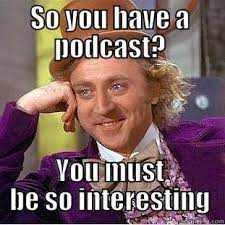

In [40]:
#currently i'm passing new blog as text but i hope you understand we can take input from any source be it documents or URL directly. taking text directly for simplicity here.

sample_blog = """
      How does Deployment Pipeline work on Fabric?
      Fabric Warehouse Deployment Issues — Part 2
      How to deploy warehouses with views in Fabric without any issues?

      Note — My blogs are 100% free to read. Stuck behind paywall? Click here.

      If you are working on Fabric and need to deploy content from one workspace to another, you might have faced multiple issues, especially while deploying warehouses.

      I had written about this earlier as well, where I discussed potential problems and solutions that might occur during warehouse deployment. This blog is a continuation of the previous one since I found new issues and solutions for deploying items in Fabric.


      Dependency during deployment
      Fabric assumes that you have already deployed the dependent items of the current item you want to deploy.

      For example, if you deploy a pipeline that contains a notebook that hasn’t been deployed yet, the deployment will ultimately fail. To fix this, you need to deploy the notebook before deploying the Data Factory pipeline. You can do this simply by clicking “Select related” on the deployment interface.


      Similarly, for Power BI reports, you can find linked items in Fabric by clicking on “View Lineage” for each item.


      They also have documentation where you can read certain sections to better understand the deployment process.


      Screenshot from Microsoft Learn Document
      But my recent observation is that warehouses not only fail when no tables are created in the lakehouses but also when a table used in the warehouse is missing from the lakehouse referenced in the view query.

      For example, if you have a table in lakehouse_1 and deploy the warehouse before creating that table in the target workspace, the warehouse will not be deployed. We have discussed this earlier.

      Deploying Fabric Warehouse with Views
      My recent observation is that if you create a view in the warehouse that refers to another view in the same warehouse, it will cause an error.

      For example, if you create a view wh.view_1 and use it in another view view_2 within the same warehouse — where view_1 is referenced somewhere in the query — Fabric does not support this yet. As a result, the deployment will fail with the following error message: ‘DmsImportDatabaseException’.


      Error when you deploy views referring to another views
      As of now, there is no way to deploy a warehouse with views that reference other views inside the query.

      The only potential solution is to delete the view from your source workspace and then recreate it in the target workspace after deployment. This could be a one-time activity, but there must be at least one warehouse with views that you are referring to, in order to deploy a view.

      This is a simple yet frustrating bug in Fabric that you should keep in mind during deployment.

      I have shared my experiences with Fabric through blogs that you can refer to during your development. I’m sure they will be helpful.

      """


In [41]:
# Extract relevant search keywords/phrases from the query
search_keywords = extract_keywords(sample_blog)
print("Extracted Keywords:", search_keywords)

Extracted Keywords: ['warehouse deployment', 'deployment fabric', 'deploying fabric', 'deploy warehouse', 'deploy warehouses']


In [42]:
results = table.search(
    " ".join(search_keywords),  # Use extracted keywords for FTS + vector search
    query_type="hybrid",
    fts_columns=["headings", "content"],
    vector_column_name="embedding"
).rerank(reranker=reranker).limit(3).to_list()

formatted_strings= []
for record in results:
    # Retrieve values with default empty strings if keys are missing
    title = record.get("title", "")
    headings = record.get("headings", "")
    content = record.get("content", "")

    # Format the string as "Title - {title}, Headings - {headings}, Content - {content}"
    formatted_string = f"Title - {title}, Headings - {headings}, Content - {content}"

    # Append the formatted string to the list
    formatted_strings.append(formatted_string)

# Combine all formatted strings into a single string with line breaks. We'll pass this as context to LLM for Script generation.
context = "\n\n\n".join(f"Reference : {i} -> {x}" for i, x in enumerate(formatted_strings))
print(context)

Reference : 0 -> Title - Microsoft Fabric Warehouse Deployment Issue(s) and Potential Solution(s) — DmsImportDatabaseException, Headings - ['UselessAI.in', 'HOW TO SOLVE THIS ERROR — “DMSIMPORTDATABASEEXCEPTION”', 'How to deploy warehouses in Microsoft Fabric without database exception?', 'Published in UselessAI.in', 'Written by Shresth Shukla', 'Responses (1)'], Content - Sign up
Sign in
Sign up
Sign in
Home
Library
Stories
Stats
Home
Newsletter
About
Follow publication
WE READ. WE BUILD.  — Learning AI by reading and building.
Follow publication
Member-only story
Shresth Shukla
Follow
UselessAI.in
--
1
Share
NOTE: If you are unable to read this article due to a membership restriction, you can access it for free using this link — CLICK HERE. ❤
Who am I? -> Hi, Shresth Shukla this side. I’m currently working with one of the Data and AI teams at EY and use Microsoft Fabric in my day-to-day tasks related to Data Engineering, Analytics & AI. Writing this blog post was fun, and I learned a

In [44]:
#using gemini to generate transcript
script = generate_conversation(sample_blog, "LanecDB", speakers_list, context)

In [48]:
pprint(script)

[{'speaker': 'Shresth',
  'text': "Hey everyone, and welcome to the podcast! Today, we're diving deep "
          'into the world of Fabric deployments, particularly around '
          'warehouses and those tricky views.'},
 {'speaker': 'Arjun',
  'text': "Yeah, deployments can be a real headache.  Especially when you're "
          'dealing with complex dependencies.'},
 {'speaker': 'Geet',
  'text': "Absolutely!  I've run into so many roadblocks. It's like navigating "
          'a maze blindfolded sometimes.'},
 {'speaker': 'Shresth',
  'text': 'Tell me about it! In a recent article I wrote, I discussed some of '
          'the common issues and solutions, building on a previous post where '
          "I tackled the dreaded 'DmsImportDatabaseException'."},
 {'speaker': 'Arjun',
  'text': "Oh, I remember that one. It's usually related to missing tables in "
          'the target lakehouse, right?'},
 {'speaker': 'Shresth',
  'text': 'Exactly.  Fabric expects all dependencies to be de

In [60]:
#not mandatory but could be used as context for next blog if saved into another table. We can involve mutiple retrievers and infact use agents too :)
save_conversation(script)

Conversation saved to ./conversation/conversation.json


In [56]:
#to generate audio using elevenlabs

generate_audio(script, speakers_map) #speakers_map is defined in config cell


['audio-files/0_Shresth.mp3',
 'audio-files/1_Arjun.mp3',
 'audio-files/2_Geet.mp3',
 'audio-files/3_Shresth.mp3',
 'audio-files/4_Arjun.mp3',
 'audio-files/5_Shresth.mp3',
 'audio-files/6_Geet.mp3',
 'audio-files/7_Arjun.mp3',
 'audio-files/8_Shresth.mp3',
 'audio-files/9_Geet.mp3',
 'audio-files/10_Shresth.mp3',
 'audio-files/11_Arjun.mp3',
 'audio-files/12_Shresth.mp3',
 'audio-files/13_Geet.mp3',
 'audio-files/14_Shresth.mp3',
 'audio-files/15_Arjun.mp3',
 'audio-files/16_Geet.mp3',
 'audio-files/17_Shresth.mp3',
 'audio-files/18_Arjun.mp3',
 'audio-files/19_Shresth.mp3',
 'audio-files/20_Geet.mp3',
 'audio-files/21_Arjun.mp3',
 'audio-files/22_Shresth.mp3']

In [57]:
output_file = "podcast.mp3"
merge_audios("audio-files", output_file)

'podcast.mp3'

And that's it. Listen to this podcast and Stay tuned for the next one.



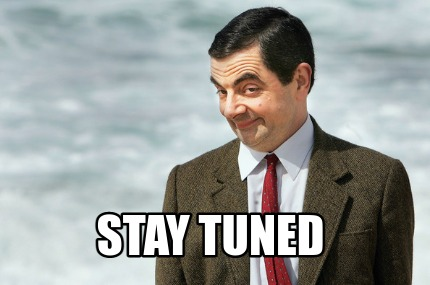